In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import xgboost as xgb

from boruta import BorutaPy

from src import classes as c
from src import functions as f

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import plotly
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

In [5]:
# creating f1 scorer
f1 = f.f1

In [6]:
modeling = c.Harness(f1)

## Baseline Dataframe

Dropping engineered features to establish the baseline score.

In [7]:
df.head()

,Target,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,...,Officer Squad,Frisk Flag,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,...,SOUTH PCT 1ST W - ROBERT,0,South,0,2015,10,16,4,11,1
1,0,NA,None,5670,1965,M,White,NA,NA,NA,...,NA,0,NA,0,2015,3,19,3,7,0
2,0,NA,None,4844,1961,M,White,White,Male,NA,...,NA,0,NA,0,2015,3,21,5,19,0
3,0,NA,None,7539,1963,M,White,NA,NA,NA,...,NA,0,NA,0,2015,4,1,2,4,0
4,0,NA,None,6973,1977,M,White,Black,Male,NA,...,NA,0,NA,0,2015,4,3,4,0,0


In [8]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [9]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [10]:
baseline_df = f.framer(df, [], excluded)

In [11]:
baseline_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
1,0,NA,None,1965,M,White,NA,NA,NA,NA,NA,NA


In [12]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Weapon Type               46960 non-null  object
 3   Officer YOB               46960 non-null  int64 
 4   Officer Gender            46960 non-null  object
 5   Officer Race              46960 non-null  object
 6   Subject Perceived Race    46960 non-null  object
 7   Subject Perceived Gender  46960 non-null  object
 8   Initial Call Type         46960 non-null  object
 9   Call Type                 46960 non-null  object
 10  Officer Squad             46960 non-null  object
 11  Precinct                  46960 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.3+ MB


In [13]:
X, y = f.Xy(baseline_df)

In [14]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression

In [15]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [16]:
baseline = make_pipeline(preprocessing_mm, LR)

In [17]:
baseline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [18]:
#scoring the model
f1_score(y_train, baseline.predict(X_train))

0.3276439089692102

In [19]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'LR Baseline', 'Log Reg, min/max')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline has an average F1 of 0.3084601376131168


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


array([0.32475083, 0.31168831, 0.31262855, 0.28534814, 0.30788486])

## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


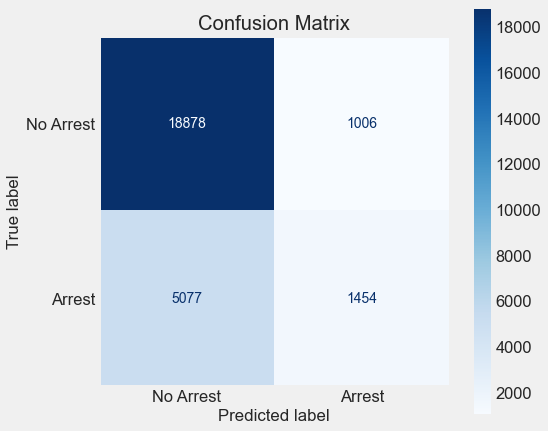

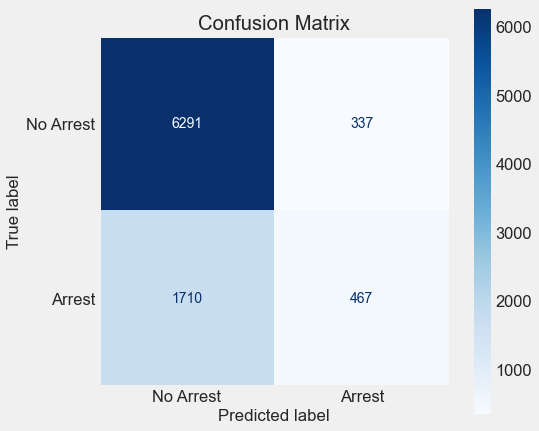

,Train F1,Test F1
0,0.323435,0.313318


In [20]:
f.subsplit_test(X_train, y_train, baseline)

## Baseline Logistic Regression w/smote

In [21]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [22]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [23]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5337012539057744

In [24]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR Baseline SMOTE', 'Log Reg min/max')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline SMOTE has an average F1 of 0.5230351427268607


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


array([0.52399117, 0.51822025, 0.52830949, 0.52266667, 0.52198814])

In [25]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR Baseline SMOTE,0.523035,Log Reg min/max


## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


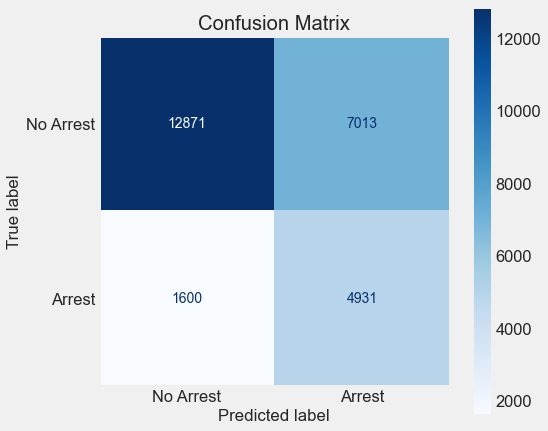

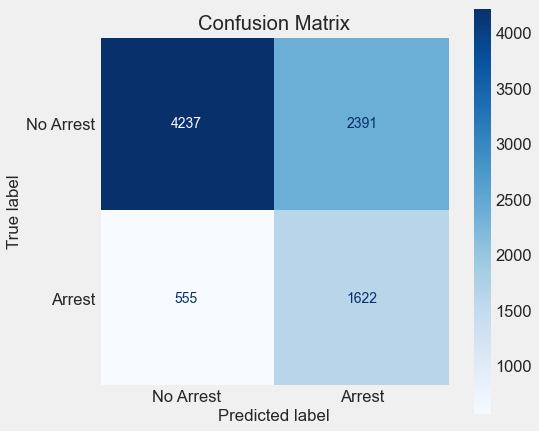

,Train F1,Test F1
0,0.533802,0.524071


In [26]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Dropping Subject and Officer Race Nulls

In [27]:
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')]

In [28]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [29]:
# excluding Officer ID, 'Final Call Type', Frisk Flag & time features
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [30]:
dropped_df = f.framer(df, [], excluded)

In [31]:
dropped_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
2,0,NA,None,1961,M,White,White,Male,NA,NA,NA,NA


In [32]:
X, y = f.Xy(dropped_df)

In [33]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression w/SMOTE on Dropped Nulls Data

In [34]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [35]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [36]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5369104579630894

In [37]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR Baseline SMOTE', 'LR, mm, Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR Baseline SMOTE has an average F1 of 0.5220253556914993


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


array([0.51851852, 0.52690009, 0.52131701, 0.52583979, 0.51755137])

In [38]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
2,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
1,LR Baseline SMOTE,0.523035,Log Reg min/max


## Sub-Splitting the Training Data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


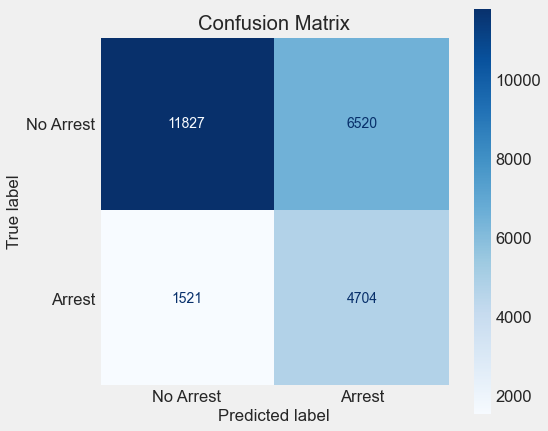

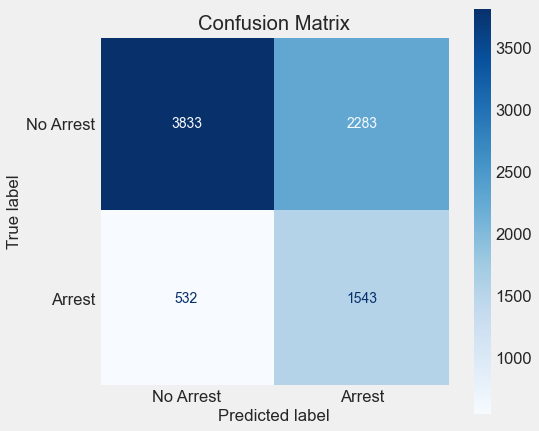

,Train F1,Test F1
0,0.539171,0.522962


In [39]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Investigating the Data More Closely

In [40]:
cols = baseline_df.columns
for col in cols:
    print(f'{df[col].value_counts()}\n')

0    32618
1    11067
Name: Target, dtype: int64

26 - 35         14651
36 - 45          9360
18 - 25          8828
46 - 55          5693
56 and Above     2228
1 - 17           1853
NA               1072
Name: Subject Age Group, dtype: int64

None                                    30763
NA                                      10307
Lethal Cutting Instrument                1417
Knife/Cutting/Stabbing Instrument         575
Handgun                                   269
Firearm Other                              94
Blunt Object/Striking Implement            78
Club, Blackjack, Brass Knuckles            46
Firearm                                    33
Mace/Pepper Spray                          24
Other Firearm                              18
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        8
None/Not Applicable                         7
Fire/Incendiary Device                      6
Rifle                

In [41]:
baseline_df['Officer YOB'].describe()

count    46960.000000
mean      1982.972764
std          9.079240
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

## Creating & Testing Officer Age Feature
Creating `Officer Age` feature, dropping invalid ages and `Officer YOB` feature.

In [42]:
df['Officer Age'] = df['Reported Year'] - df['Officer YOB']
df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(subset = ['Officer Age'], inplace=True)

In [43]:
df.drop('Officer YOB', axis=1, inplace=True)

In [44]:
age_df = f.framer(df, [], excluded)

In [45]:
age_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Age
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,31.0
2,0,NA,None,M,White,White,Male,NA,NA,NA,NA,54.0


In [46]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Weapon Type               43660 non-null  object 
 3   Officer Gender            43660 non-null  object 
 4   Officer Race              43660 non-null  object 
 5   Subject Perceived Race    43660 non-null  object 
 6   Subject Perceived Gender  43660 non-null  object 
 7   Initial Call Type         43660 non-null  object 
 8   Call Type                 43660 non-null  object 
 9   Officer Squad             43660 non-null  object 
 10  Precinct                  43660 non-null  object 
 11  Officer Age               43660 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 4.3+ MB


In [47]:
X, y = f.Xy(age_df)

In [48]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [49]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [50]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5399632619932505

In [51]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Dropped Nulls, mm, officer age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5238746692203137


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.52695389, 0.52906237, 0.52914988, 0.52506994, 0.50913727])

In [52]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
2,LR Baseline SMOTE,0.523035,Log Reg min/max
3,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


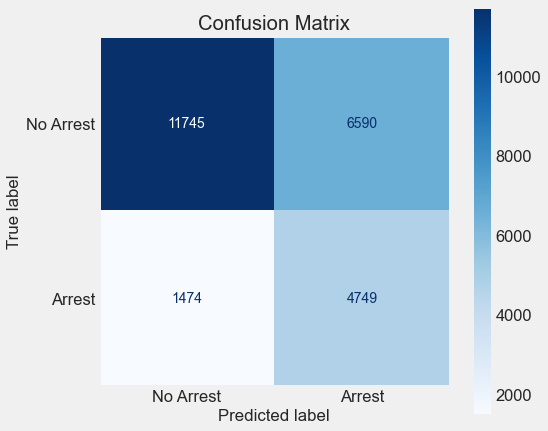

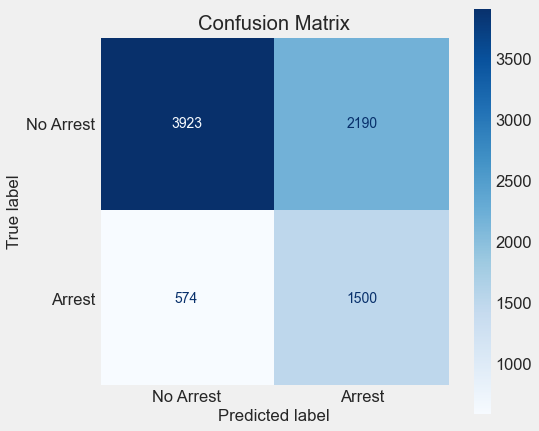

,Train F1,Test F1
0,0.540827,0.520472


In [53]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Creating Racial Affinity Feature

In [54]:
df['Racial Affinity'] = [1 if df['Subject Perceived Race'][row]\
                         == df['Officer Race'][row] else 0 for row in df.index]

In [55]:
df.head(3)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity
0,1,NA,None,7500,M,Black,Asian,Male,NA,NA,...,South,0,2015,10,16,4,11,1,31.0,0
2,0,NA,None,4844,M,White,White,Male,NA,NA,...,NA,0,2015,3,21,5,19,0,54.0,1
4,0,NA,None,6973,M,White,Black,Male,NA,NA,...,NA,0,2015,4,3,4,0,0,38.0,0


In [56]:
# excluding Officer ID, 'Final Call Type', and Frisk Flag
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age']

In [57]:
RA_df = f.framer(df, [], excluded)

In [58]:
RA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Racial Affinity
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,M,White,White,Male,NA,NA,NA,NA,1


In [59]:
X, y = f.Xy(RA_df)

In [60]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [61]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [62]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5355088825459039

In [63]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, racial affinity')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5213930960426445


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


array([0.52923343, 0.52016044, 0.52238176, 0.52404572, 0.51114413])

In [64]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
4,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
1,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
2,LR Baseline SMOTE,0.523035,Log Reg min/max
3,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


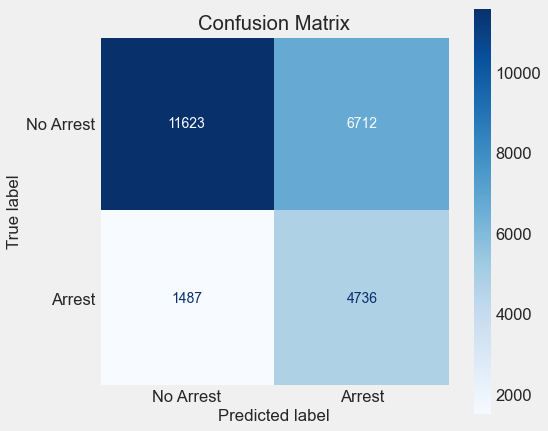

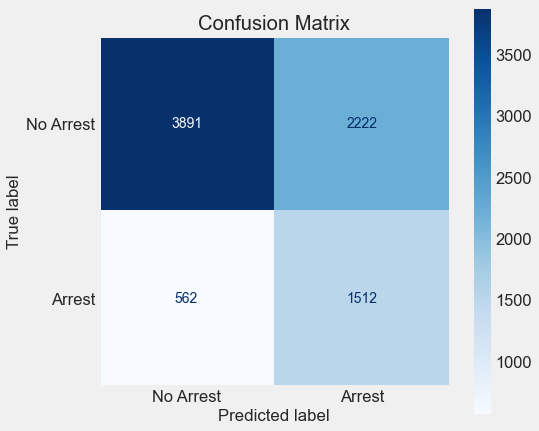

,Train F1,Test F1
0,0.536019,0.520661


In [65]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Gender Affinity Feature

In [66]:
df['Officer Gender'].value_counts()

M    38657
F     5003
Name: Officer Gender, dtype: int64

In [67]:
df['Officer Gender'] = df['Officer Gender'].apply(lambda x: 'Male' if x=='M' else 'Female')

In [68]:
df['Gender Affinity'] = [1 if df['Subject Perceived Gender'][row]\
                         == df['Officer Gender'][row] else 0 for row in df.index]

In [69]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,0,2015,10,16,4,11,1,31.0,0,1
2,0,NA,None,4844,Male,White,White,Male,NA,NA,...,0,2015,3,21,5,19,0,54.0,1,1


In [70]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity']

In [71]:
GA_df = f.framer(df, [], excluded)

In [72]:
GA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Gender Affinity
0,1,NA,None,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,1
2,0,NA,None,Male,White,White,Male,NA,NA,NA,NA,1


In [73]:
X, y = f.Xy(GA_df)

In [74]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [75]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [76]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5350903294367694

In [77]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, gender affinity')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5221593045072792


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


array([0.52747728, 0.52113271, 0.5235381 , 0.52695127, 0.51169715])

In [78]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
2,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
5,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
3,LR Baseline SMOTE,0.523035,Log Reg min/max
4,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


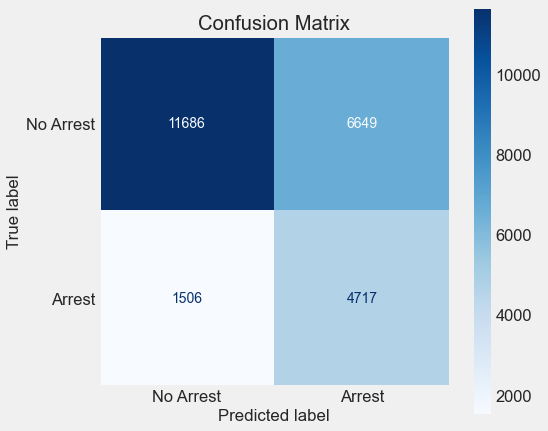

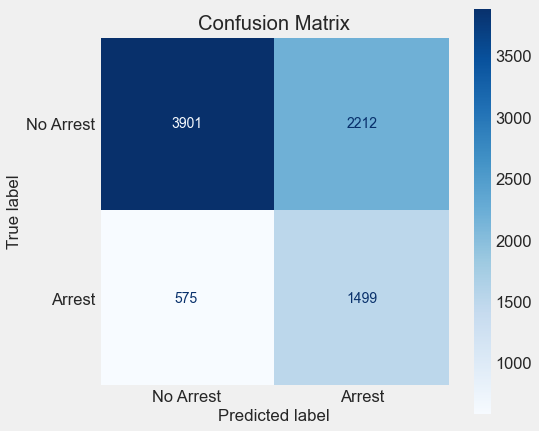

,Train F1,Test F1
0,0.536358,0.518237


In [79]:
f.subsplit_test(X_train, y_train, baseline_smote)

### Weapon Type

In [80]:
# checking weapon types
df['Weapon Type'].unique()

array(['None', 'Firearm Other', 'Handgun', 'Lethal Cutting Instrument',
       'NA', 'Club, Blackjack, Brass Knuckles',
       'Knife/Cutting/Stabbing Instrument', 'Other Firearm',
       'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
       'Firearm (unk type)', 'Mace/Pepper Spray', 'None/Not Applicable',
       'Club', 'Rifle', 'Firearm', 'Taser/Stun Gun', 'Shotgun',
       'Brass Knuckles', 'Automatic Handgun', 'Blackjack',
       'Personal Weapons (hands, feet, etc.)'], dtype=object)

In [81]:
NONE= ['None', 'NA','None/Not Applicable']

GUN = ['Firearm Other', 'Handgun', 'Other Firearm',
        'Rifle', 'Firearm (unk type)', 'Firearm',
        'Shotgun', 'Automatic Handgun']

KNIFE = ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']

OTHER = ['Club, Blackjack, Brass Knuckles',
         'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
         'Mace/Pepper Spray', 'Club', 'Taser/Stun Gun',
         'Brass Knuckles','Blackjack',
         'Personal Weapons (hands, feet, etc.)']

In [82]:
df['Weapon Bins'] = df['Weapon Type'].copy()

In [83]:
df['Weapon Bins']

0                                     None
2                                     None
4                                     None
5                                     None
6                                     None
                       ...                
46955    Knife/Cutting/Stabbing Instrument
46956                                   NA
46957                        Other Firearm
46958                                   NA
46959                                   NA
Name: Weapon Bins, Length: 43660, dtype: object

In [84]:
for type in NONE:
    df['Weapon Bins'].replace(type, 'NONE', inplace=True)
for type in GUN:
    df['Weapon Bins'].replace(type, 'GUN', inplace=True)
for type in KNIFE:
    df['Weapon Bins'].replace(type, 'KNIFE', inplace=True)
for type in OTHER:
    df['Weapon Bins'].replace(type, 'OTHER', inplace=True)

In [85]:
df['Weapon Bins'].value_counts(normalize=True)

NONE     0.940289
KNIFE    0.045602
GUN      0.010078
OTHER    0.004031
Name: Weapon Bins, dtype: float64

## 94% of Subjects Are Unarmed and Only 1% Have a Gun.

In [86]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,2015,10,16,4,11,1,31.0,0,1,NONE
2,0,NA,None,4844,Male,White,White,Male,NA,NA,...,2015,3,21,5,19,0,54.0,1,1,NONE


In [87]:
excluded = ['Weapon Type', 'Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity']

In [88]:
WB_df = f.framer(df, [], excluded)

In [89]:
WB_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Bins
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,NONE
2,0,NA,Male,White,White,Male,NA,NA,NA,NA,NONE


In [90]:
X, y = f.Xy(WB_df)

In [91]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [92]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [93]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5350340136054421

In [94]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, Weapon Bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5217121278639294


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


array([0.52365522, 0.52064027, 0.52589641, 0.52511317, 0.51325557])

In [95]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
2,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
3,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
4,LR Baseline SMOTE,0.523035,Log Reg min/max
5,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


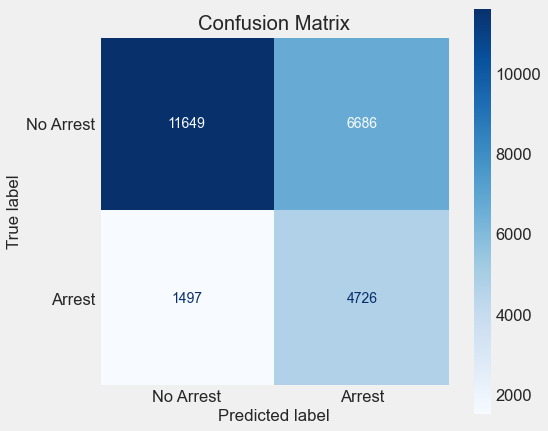

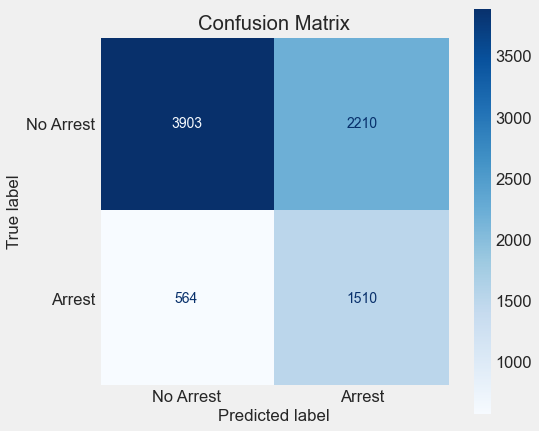

,Train F1,Test F1
0,0.53598,0.521229


In [96]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing Weapon Flag
The weapon flag (0 = no weapon) has been excluded from tests up to this point.

In [97]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Type', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins']

In [98]:
WF_df = f.framer(df, [], excluded)

In [99]:
WF_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Flag
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,Male,White,White,Male,NA,NA,NA,NA,0


In [100]:
X, y = f.Xy(WF_df)

In [101]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [102]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [103]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5343095521879788

In [104]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, weapon flag')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5213279897908258


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


array([0.52567714, 0.52049007, 0.52316765, 0.52572659, 0.5115785 ])

In [105]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
7,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
1,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
2,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
3,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
4,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
5,LR Baseline SMOTE,0.523035,Log Reg min/max
6,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


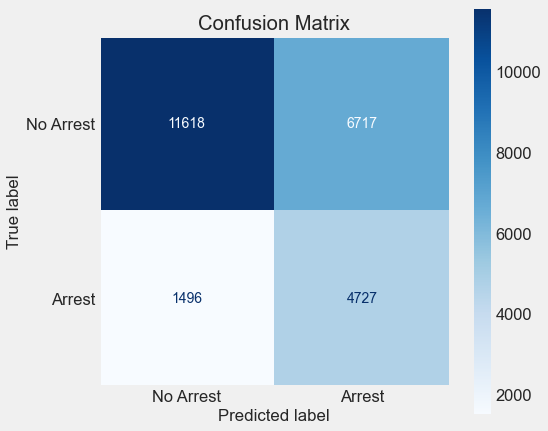

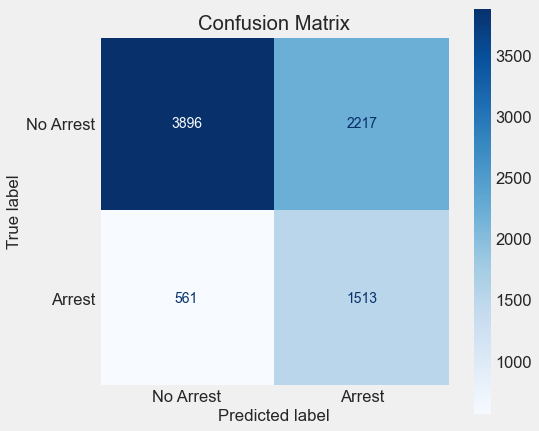

,Train F1,Test F1
0,0.535122,0.521365


In [106]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binarizing Initial Call Type
0 = no call information provided.

In [107]:
df['Initial Call Bin'] = df['Initial Call Type'].copy()

In [108]:
df['Initial Call Bin'] = df['Initial Call Bin'].replace('NA', 0)
df['Initial Call Bin'] = df['Initial Call Bin'].map(lambda x: 1 if x!=0 else 0)

In [109]:
df['Initial Call Bin'].value_counts()

1    31268
0    12392
Name: Initial Call Bin, dtype: int64

In [110]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 'Initial Call Type']

In [111]:
ICB_df = f.framer(df, [], excluded)

In [112]:
ICB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Officer Squad,Precinct,Initial Call Bin
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,Male,White,White,Male,NA,NA,NA,0


In [113]:
X, y = f.Xy(ICB_df)

In [114]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [115]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [116]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5099810803505928

In [117]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, Initial Call Binary')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5039133895106931


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


array([0.50731707, 0.50972763, 0.51009033, 0.50311526, 0.48931665])

In [118]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
8,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
1,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
2,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
3,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
4,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
5,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
6,LR Baseline SMOTE,0.523035,Log Reg min/max
7,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


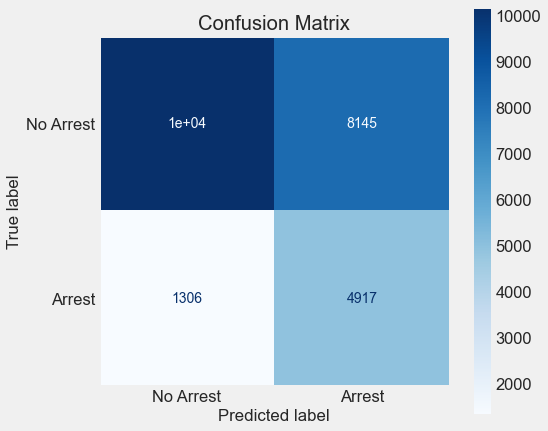

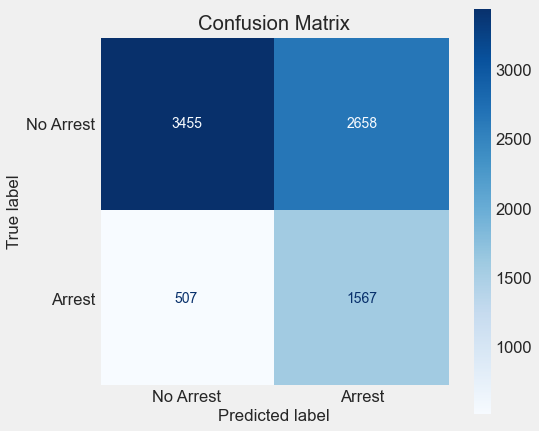

,Train F1,Test F1
0,0.50993,0.497539


In [119]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning Call Types

In [120]:
types = df['Call Type'].unique()

In [121]:
replace_list = [x for x in types if (x!='911') and (x!='ONVIEW')]

In [122]:
df['Call Type Bins'] = df['Call Type'].copy()

In [123]:
df['Call Type Bins'] = df['Call Type Bins'].replace(replace_list, 'OTHER')

In [124]:
df['Call Type Bins'].value_counts(normalize=True)

911       0.452268
OTHER     0.361361
ONVIEW    0.186372
Name: Call Type Bins, dtype: float64

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Weapon Type               43660 non-null  object 
 3   Officer ID                43660 non-null  object 
 4   Officer Gender            43660 non-null  object 
 5   Officer Race              43660 non-null  object 
 6   Subject Perceived Race    43660 non-null  object 
 7   Subject Perceived Gender  43660 non-null  object 
 8   Initial Call Type         43660 non-null  object 
 9   Final Call Type           43660 non-null  object 
 10  Call Type                 43660 non-null  object 
 11  Officer Squad             43660 non-null  object 
 12  Frisk Flag                43660 non-null  int64  
 13  Precinct                  43660 non-null  object 
 14  Weapon

In [126]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type']

In [127]:
BCT_df = f.framer(df, [], excluded)

In [128]:
BCT_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Officer Squad,Precinct,Call Type Bins
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,OTHER
2,0,NA,None,Male,White,White,Male,NA,NA,NA,OTHER


In [129]:
X, y = f.Xy(BCT_df)

In [130]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [131]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [132]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5365332877823803

In [133]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Dropped Nulls, mm, call type bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE  has an average F1 of 0.5211482076394486


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


array([0.52222945, 0.52127885, 0.52327786, 0.52697185, 0.51198303])

In [134]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
9,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
2,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
3,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
4,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
5,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
6,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
7,LR Baseline SMOTE,0.523035,Log Reg min/max
8,LR SMOTE,0.523875,"Dropped Nulls, mm, officer age"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


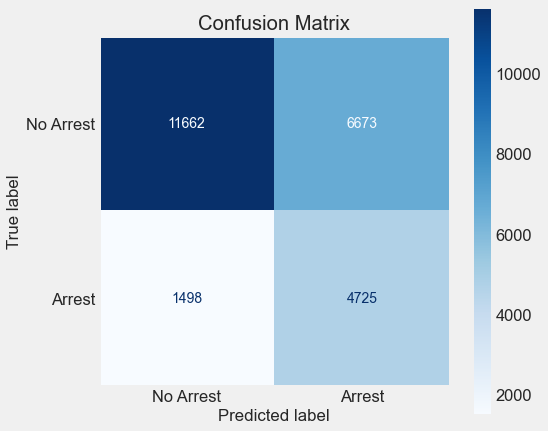

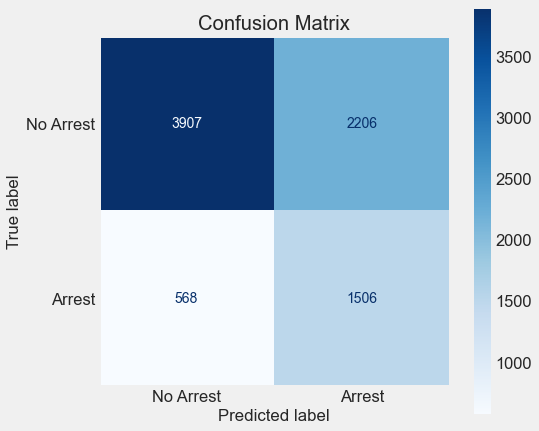

,Train F1,Test F1
0,0.536292,0.520567


In [135]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning the Squad Data
The squads look like they can be binned into precinct goups and a training group.

In [136]:
df['Officer Squad Bins'] = df['Officer Squad'].copy()

In [137]:
df['Officer Squad Bins'] = df['Officer Squad Bins'].map(lambda x: x[0])

In [138]:
df['Officer Squad Bins'].value_counts(normalize=True)

W    0.277119
N    0.253275
S    0.210009
E    0.136395
T    0.110330
C    0.009345
G    0.001306
H    0.000710
M    0.000412
B    0.000206
J    0.000206
D    0.000183
A    0.000183
R    0.000160
P    0.000115
Z    0.000023
V    0.000023
Name: Officer Squad Bins, dtype: float64

In [139]:
proportions = df['Officer Squad Bins'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .02].index
for i in cutoff_idx:
    df['Officer Squad Bins'].replace(i, 'OTHER', inplace=True)

In [140]:
df['Officer Squad Bins'].value_counts()

W        12099
N        11058
S         9169
E         5955
T         4817
OTHER      562
Name: Officer Squad Bins, dtype: int64

In [141]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad']

In [142]:
BSQ_df = f.framer(df, [], excluded)

In [143]:
BSQ_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Precinct,Officer Squad Bins
0,1,NA,None,Male,Black,Asian,Male,NA,NA,South,S
2,0,NA,None,Male,White,White,Male,NA,NA,NA,N


In [144]:
X, y = f.Xy(BSQ_df)

In [145]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [146]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [147]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.52002822630858

In [148]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Dropped Nulls, mm, Squad Bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5131967423116138


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.51906467, 0.51236603, 0.51989281, 0.51051426, 0.50414594])

In [149]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
10,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
2,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
3,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
4,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
5,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
6,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
7,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
8,LR Baseline SMOTE,0.523035,Log Reg min/max


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


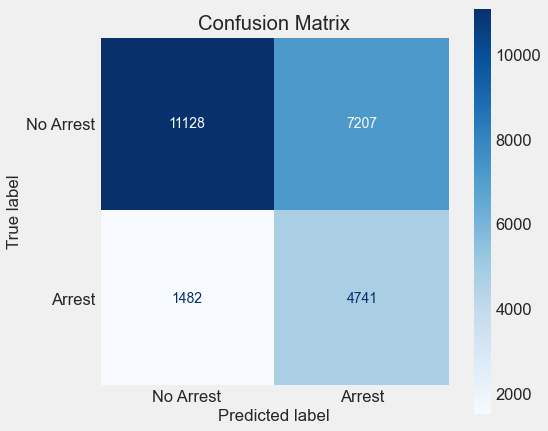

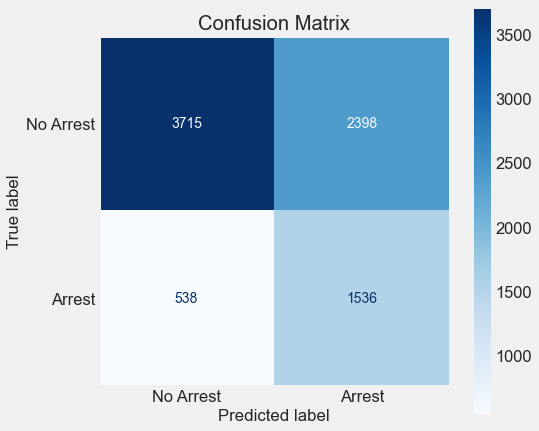

,Train F1,Test F1
0,0.52182,0.511318


In [150]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning Officer Race

In [151]:
df['Officer Race Bins'] = df['Officer Race'].copy()

In [152]:
df['Officer Race Bins'].replace('White', 1, inplace=True)

In [153]:
df['Officer Race Bins'] = df['Officer Race Bins'].apply(lambda x: 0 if x!=1 else 1)

In [154]:
df['Officer Race Bins'].value_counts()

1    34103
0     9557
Name: Officer Race Bins, dtype: int64

In [155]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins',
            'Officer Race']

In [156]:
ORB_df = f.framer(df, [], excluded)

In [157]:
ORB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Race Bins
0,1,NA,None,Male,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
2,0,NA,None,Male,White,Male,NA,NA,NA,NA,1


In [158]:
X, y = f.Xy(ORB_df)

In [159]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [160]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [161]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5361114661894415

In [162]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Dropped Nulls, mm, Officer Race Bins')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5225111785772603


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


array([0.52597403, 0.52469396, 0.52419016, 0.5257754 , 0.51192235])

In [163]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
11,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


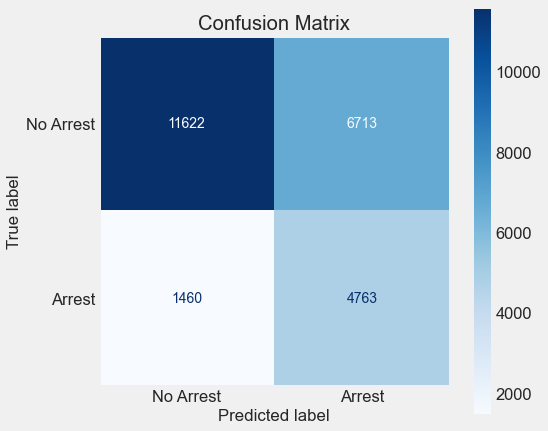

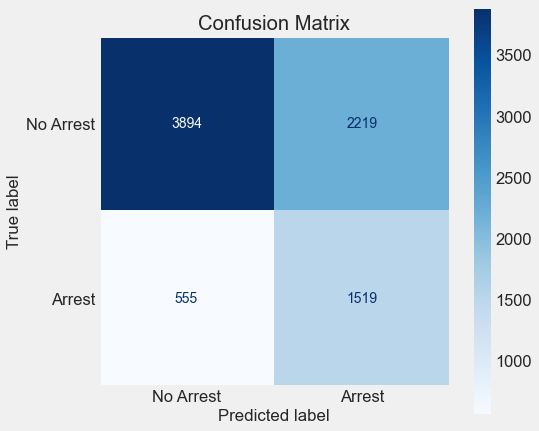

,Train F1,Test F1
0,0.538222,0.522712


In [164]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing on Top Features w/o Time

In [165]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [166]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag',
            'Racial Affinity', 'Weapon Bins', 'Officer Race',
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins']

In [167]:
df_6 = f.framer(df, [], excluded)

In [168]:
df_6.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Age,Gender Affinity,Officer Race Bins
0,1,NA,None,Male,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,31.0,1,0
2,0,NA,None,Male,White,Male,NA,NA,NA,NA,54.0,1,1


In [169]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Weapon Type               43660 non-null  object 
 3   Officer Gender            43660 non-null  object 
 4   Subject Perceived Race    43660 non-null  object 
 5   Subject Perceived Gender  43660 non-null  object 
 6   Initial Call Type         43660 non-null  object 
 7   Call Type                 43660 non-null  object 
 8   Officer Squad             43660 non-null  object 
 9   Precinct                  43660 non-null  object 
 10  Officer Age               43660 non-null  float64
 11  Gender Affinity           43660 non-null  int64  
 12  Officer Race Bins         43660 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 5.7+ MB


In [170]:
X, y = f.Xy(df_6)

In [171]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [172]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [173]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5371823298652567

In [174]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,\
                'LR SMOTE', 'Top Features w/o Time Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5251567736296799


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


array([0.52599784, 0.53180174, 0.52778365, 0.52895753, 0.51124311])

In [175]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
9,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


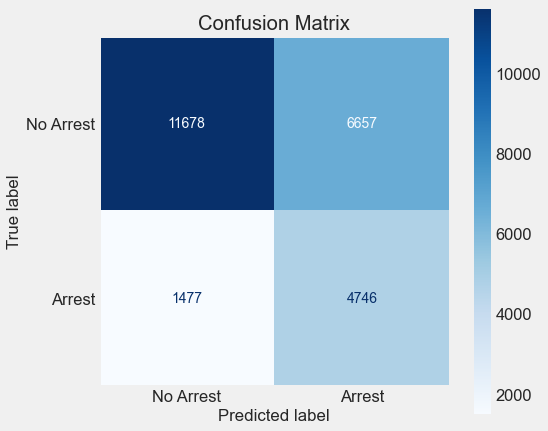

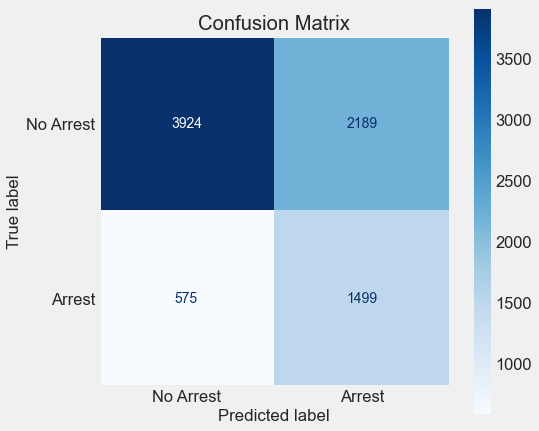

,Train F1,Test F1
0,0.538523,0.520305


In [176]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing on All Features w/o Time

In [177]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [178]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [179]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [180]:
df_7 = f.framer(df, [], excluded)

In [181]:
df_7.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,None,Male,White,White,Male,NA,NA,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,None,Male,White,Asian,Male,NA,NA,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [182]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Officer Race              42589 non-null  object 
 5   Subject Perceived Race    42589 non-null  object 
 6   Subject Perceived Gender  42589 non-null  object 
 7   Initial Call Type         42589 non-null  object 
 8   Call Type                 42589 non-null  object 
 9   Officer Squad             42589 non-null  object 
 10  Precinct                  42589 non-null  object 
 11  Beat Flag                 42589 non-null  int64  
 12  Officer Age               42589 non-null  float64
 13  Racial Affinity           42589 non-null  int64  
 14  Gend

In [183]:
X, y = f.Xy(df_7)

In [184]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [185]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [186]:
#scoring the model
f1_score(y_train,baseline_smote.predict(X_train))

0.5433360765798934

In [187]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,'LR SMOTE', 'All Features w/o Time Dropped Nulls')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5320124383913682


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


array([0.53319012, 0.5380117 , 0.52402499, 0.53377193, 0.53106345])

In [188]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
9,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


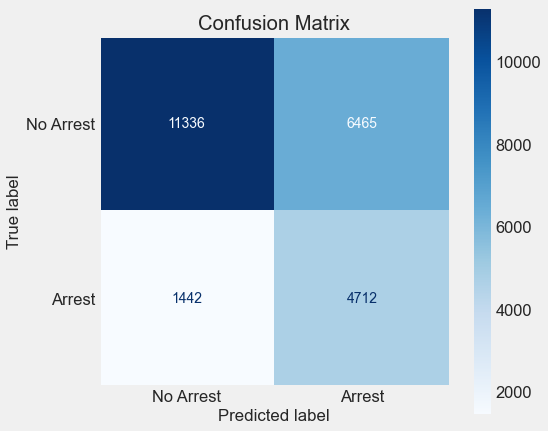

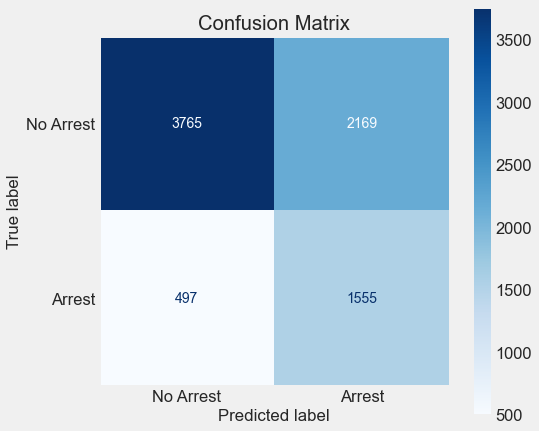

,Train F1,Test F1
0,0.543766,0.538435


In [189]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing on Top Features w/o Time Dropped Subject Age

In [190]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [191]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [192]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag',
            'Racial Affinity', 'Weapon Bins', 'Officer Race',
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins']

In [193]:
df_8 = f.framer(df, [], excluded)

In [194]:
df_8.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Age,Gender Affinity,Officer Race Bins
214,0,1 - 17,None,Male,White,Male,NA,NA,NA,NA,27.0,1,1
328,0,36 - 45,None,Male,Asian,Male,NA,NA,NA,NA,37.0,1,1


In [195]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Subject Perceived Race    42589 non-null  object 
 5   Subject Perceived Gender  42589 non-null  object 
 6   Initial Call Type         42589 non-null  object 
 7   Call Type                 42589 non-null  object 
 8   Officer Squad             42589 non-null  object 
 9   Precinct                  42589 non-null  object 
 10  Officer Age               42589 non-null  float64
 11  Gender Affinity           42589 non-null  int64  
 12  Officer Race Bins         42589 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 4.5+ MB


In [196]:
X, y = f.Xy(df_8)

In [197]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [198]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [199]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.544110654851956

In [200]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,\
                'LR SMOTE', 'Top Features w/o Time Dpd Nulls S,O Race, S Age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5307750809943184


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


array([0.53033226, 0.53682842, 0.52004287, 0.5371179 , 0.52955394])

In [201]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
9,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


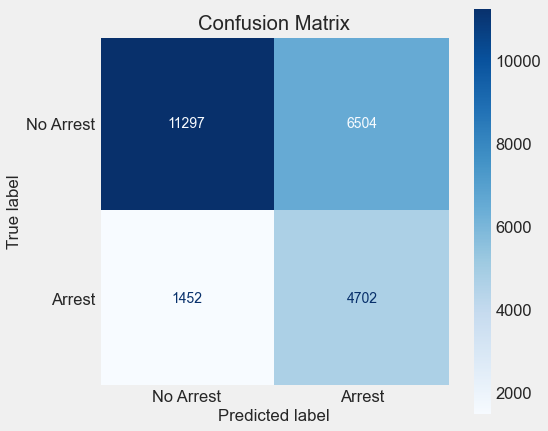

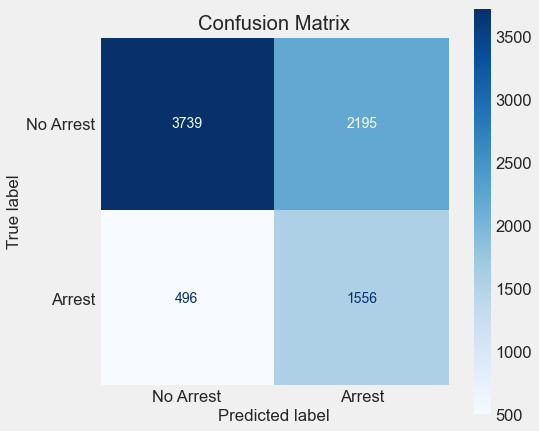

,Train F1,Test F1
0,0.541705,0.536274


In [202]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing on All Features w/o Time Dropped Subject Age

In [203]:
# Dropping Subject Age Nulls
df = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA') &\
           (df['Subject Age Group']!='NA')]

In [204]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [205]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
           'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [206]:
df_9 = f.framer(df, [], excluded)

In [207]:
df_9.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,None,Male,White,White,Male,NA,NA,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,None,Male,White,Asian,Male,NA,NA,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [208]:
df_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Officer Race              42589 non-null  object 
 5   Subject Perceived Race    42589 non-null  object 
 6   Subject Perceived Gender  42589 non-null  object 
 7   Initial Call Type         42589 non-null  object 
 8   Call Type                 42589 non-null  object 
 9   Officer Squad             42589 non-null  object 
 10  Precinct                  42589 non-null  object 
 11  Beat Flag                 42589 non-null  int64  
 12  Officer Age               42589 non-null  float64
 13  Racial Affinity           42589 non-null  int64  
 14  Gend

In [209]:
X, y = f.Xy(df_9)

In [210]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [211]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [212]:
#scoring the model
f1_score(y_train, baseline_smote.predict(X_train))

0.5433360765798934

In [213]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,\
                'LR SMOTE', 'All Features w/o Time  Dpd Nulls S,O Race, S Age')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR SMOTE has an average F1 of 0.5320124383913682


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


array([0.53319012, 0.5380117 , 0.52402499, 0.53377193, 0.53106345])

In [214]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
9,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


## Testing on Sub-Splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


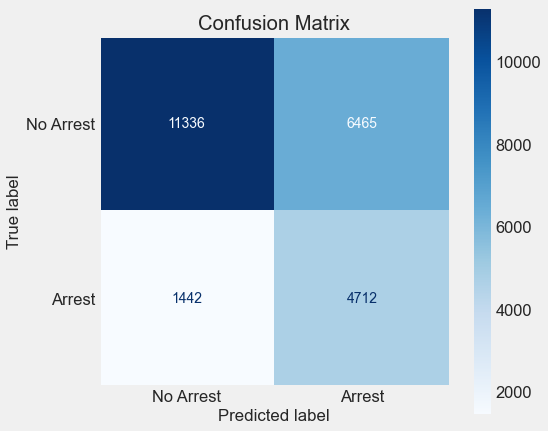

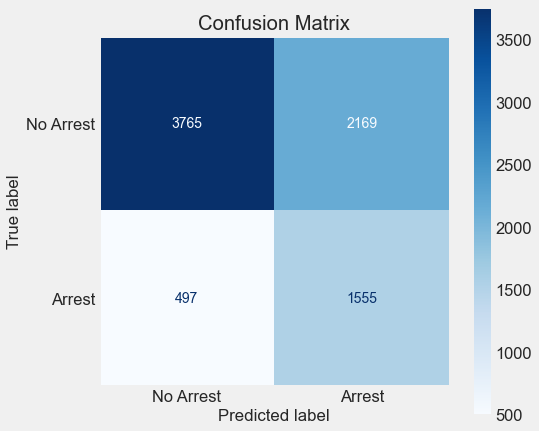

,Train F1,Test F1
0,0.543766,0.538435


In [215]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Grid Searching Parameters

In [216]:
# C = np.logspace(-3, 7, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga', 'lbfgs']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver }

# grid_clf_f1 = GridSearchCV(baseline_smote, param_grid = grid_values,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_train, y_train)

In [217]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])

In [218]:
LR_tuned = LogisticRegression(C=2.154434690031884,
                            solver='lbfgs', penalty='l2',
                            max_iter=1000, n_jobs=-1, random_state=2021)

pipeline  = make_sm_pipeline(preprocessing_mm, sm, LR_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_tuned', 'C=2.154434690031884, solver=lbfgs, penalty=l2')

LR_tuned has an average F1 of 0.532131062104727


array([0.53252908, 0.53804466, 0.52652005, 0.53377193, 0.52978959])

In [219]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
2,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
3,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
4,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
5,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
6,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"
7,LR Baseline SMOTE,0.522025,"LR, mm, Dropped Nulls"
8,LR SMOTE,0.522159,"Dropped Nulls, mm, gender affinity"
9,LR SMOTE,0.522511,"Dropped Nulls, mm, Officer Race Bins"


## Testing Tuned Model on Sub-Splits

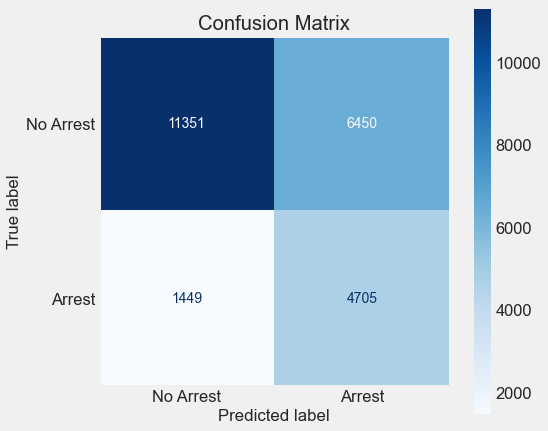

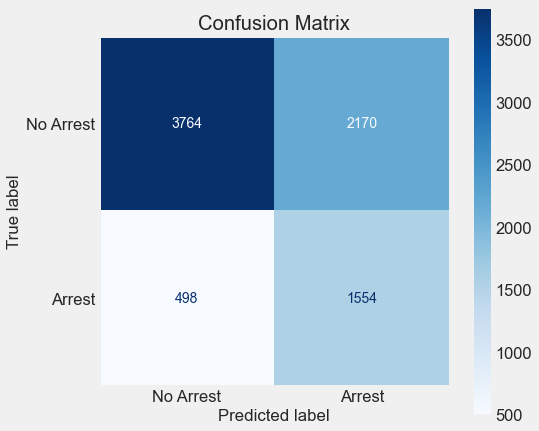

,Train F1,Test F1
0,0.543648,0.538089


In [220]:
f.subsplit_test(X_train, y_train, pipeline)

## Random Forest No Smote

In [221]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

In [222]:
rf_pipeline = make_pipeline(preprocessing_mm, RF)

In [223]:
modeling.report(rf_pipeline, X_train, y_train, 'RandomForest', 'Forest No SMOTE')

RandomForest has an average F1 of 0.38125959589404107


array([0.38234135, 0.37515127, 0.39467502, 0.38141414, 0.3727162 ])

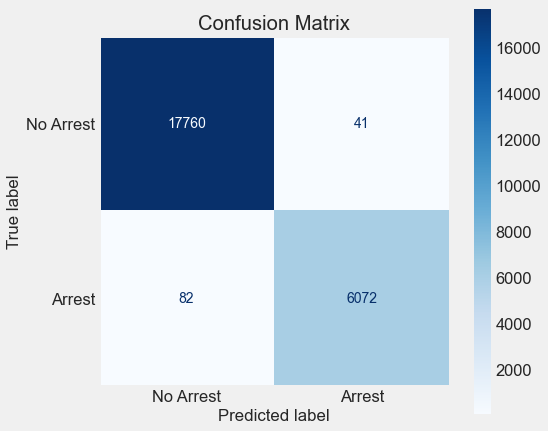

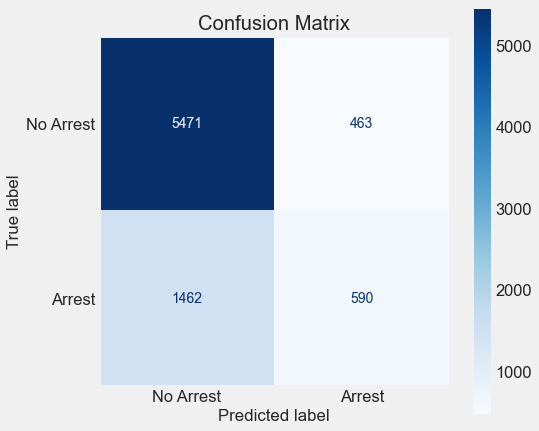

,Train F1,Test F1
0,0.989973,0.380032


In [224]:
f.subsplit_test(X_train, y_train, rf_pipeline)

## Random Forest w/ SMOTE

In [225]:
rf_sm_pipeline = make_sm_pipeline(preprocessing_mm, sm, RF)

In [226]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RandomForest', 'Forest SMOTE')

RandomForest has an average F1 of 0.4203497534865745


array([0.42326909, 0.41923642, 0.43506261, 0.4122645 , 0.41191615])

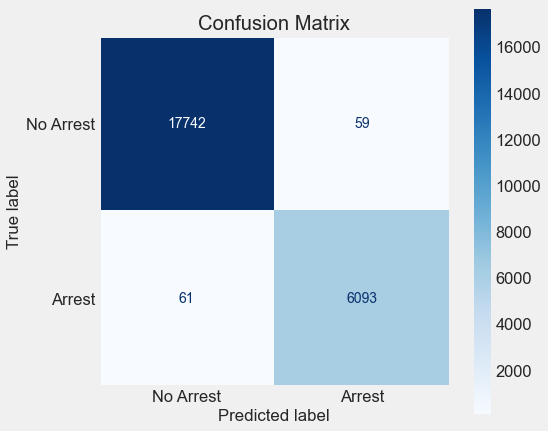

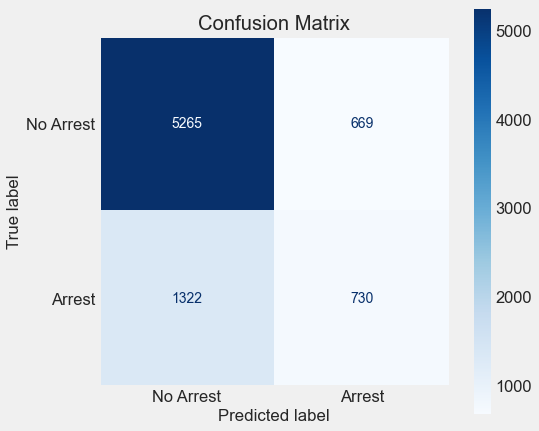

,Train F1,Test F1
0,0.990249,0.423066


In [227]:
f.subsplit_test(X_train, y_train, rf_sm_pipeline)

## Tuning RF no SMOTE

In [228]:
# max_depth = [2, 3, 5, None]
# min_samples_split = [2, 5, 10]
# class_weight = ['balanced', 'balanced_subsample']
# max_features = [None, 'auto', 'log2' ]

# grid_values = {'randomforestclassifier__max_features': max_features,
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#               'randomforestclassifier__class_weight':class_weight}

# grid_rf_f1 = GridSearchCV(rf_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [229]:
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

## Tuned Random Forest

In [230]:
RF2 = RandomForestClassifier(criterion='gini',
                            max_depth=5, min_samples_split=2,
                            class_weight='balanced_subsample',
                            n_jobs=-1, random_state=2021)

In [231]:
rf_pipeline = make_pipeline(preprocessing_mm, RF2)

In [232]:
modeling.report(rf_pipeline, X_train, y_train, 'RF Tuned No SMOTE', 'criterion=gini,\
                            max_depth=5, min_samples_split=2,\
                            class_weight=balanced_subsample')

RF Tuned No SMOTE has an average F1 of 0.4995684663039711


array([0.49726685, 0.50106925, 0.50216306, 0.50074565, 0.49659751])

In [233]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
19,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
3,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
4,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
5,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
6,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
7,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"
8,LR SMOTE,0.521712,"Dropped Nulls, mm, Weapon Bins"


## Testing on Subsplits

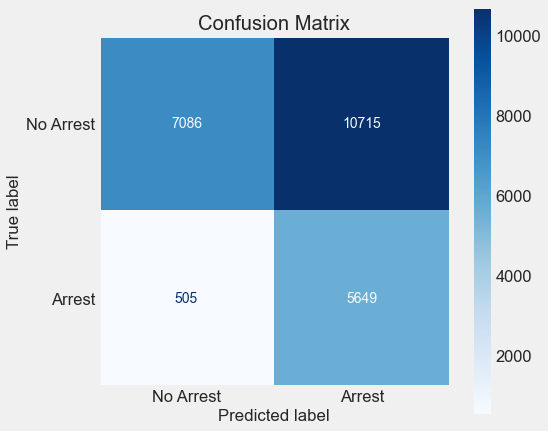

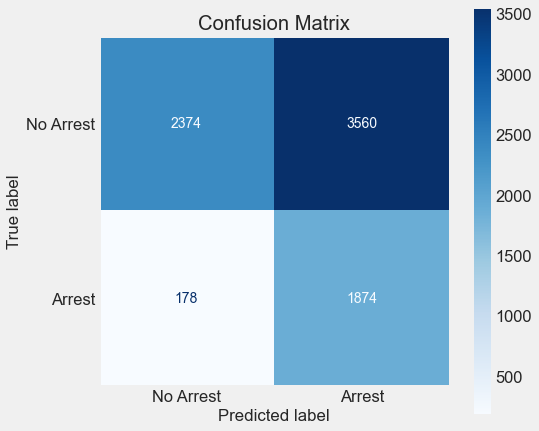

,Train F1,Test F1
0,0.501732,0.500668


In [234]:
f.subsplit_test( X_train, y_train, rf_pipeline)

## Tuning RF SMOTE

In [235]:
# rf_pipeline.get_params().keys()

In [236]:
# max_depth = [2, 3, 5, None]
# min_samples_split = [2, 5, 10]
# class_weight = [None, 'balanced', 'balanced_subsample']
# max_features = [None, 'auto', 'log2' ]

# grid_values = {'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__class_weight':class_weight,
#                'randomforestclassifier__max_features': max_features}

# grid_rf_f1 = GridSearchCV(rf_sm_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)  

In [237]:
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])
# print('Best max_depth:', grid_rf_f1.bes t_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

## Tuned Random Forest w/SMOTE

In [238]:
RF3 = RandomForestClassifier(criterion='gini',
                            max_depth=5, min_samples_split=2,
                            class_weight='balanced_subsample',
                             max_features=None,n_jobs=-1,
                            random_state=2021)

In [239]:
rf_sm_pipeline = make_pipeline(preprocessing_mm, RF3)

In [240]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF Tuned SMOTE', 'criterion=gini,\
                            max_depth=5, min_samples_split=2,\
                            class_weight=balanced_subsample')

RF Tuned SMOTE has an average F1 of 0.5057272753159475


array([0.50727864, 0.50706595, 0.50720659, 0.50274625, 0.50433895])

In [241]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
3,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
4,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
20,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
5,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
6,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
7,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"
8,LR SMOTE,0.521393,"Dropped Nulls, mm, racial affinity"


In [242]:
rf_sm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, max_features=None,
                                        n_jobs=-1, random_state=2021))])

## Testing on Subsplits

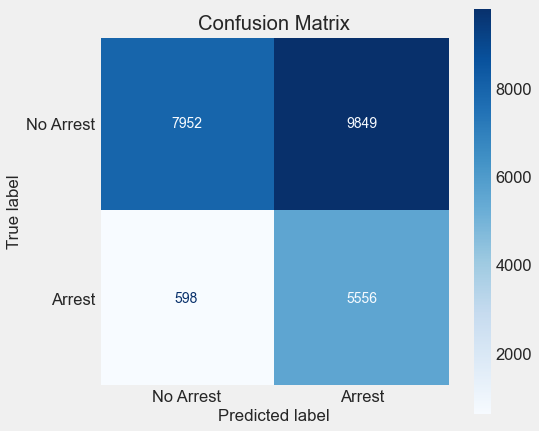

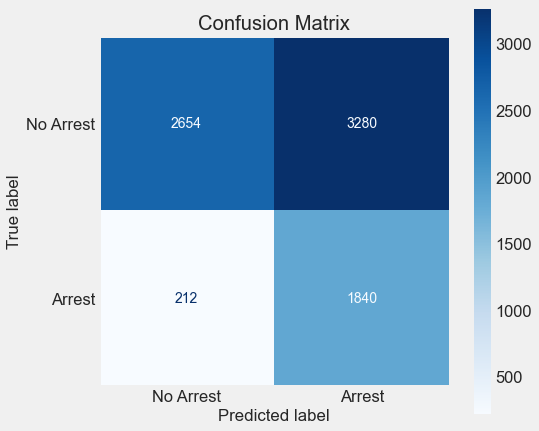

,Train F1,Test F1
0,0.515423,0.513107


In [243]:
f.subsplit_test( X_train, y_train, rf_sm_pipeline)

## Another Search

In [244]:
# criterion =['gini', 'entropy']
# max_depth = [2, 6, 10]
# min_samples_split = [5,10]
# class_weight = [None, 'balanced', 'balanced_subsample']
# max_features = [None, 'auto', 'log2' ]
# n_estimators = [10,30,50]
# min_samples_leaf = [3,6]

# grid_values = {'randomforestclassifier__n_estimators':n_estimators,
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__criterion':criterion,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__class_weight':class_weight,
#                'randomforestclassifier__max_features': max_features,
#                'randomforestclassifier__min_samples_leaf': min_samples_leaf}

# grid_rf_f1 = GridSearchCV(rf_sm_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [245]:
# print('Best criterion:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class_weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])
# print('Best min_samples_leaf:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])
# print('Best n_estimators:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__n_estimators'])

In [246]:
RF4 = RandomForestClassifier(criterion='gini',
                             n_estimators= 50,
                            max_depth=10, 
                             min_samples_split=10,
                            class_weight='balanced_subsample',
                             min_samples_leaf = 3,
                             max_features='auto',
                             n_jobs=-1,
                            random_state=2021)

In [247]:
rf_sm_pipeline = make_pipeline(preprocessing_mm, RF4)

In [248]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF 2nd Tuning', 'criterion=gini,\
                            max_depth=5, min_samples_split=2,\
                            class_weight=balanced_subsample')

RF 2nd Tuning has an average F1 of 0.5102138496788604


array([0.50856658, 0.5087001 , 0.51414934, 0.51181516, 0.50783807])

In [249]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
3,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
4,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
5,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
21,RF 2nd Tuning,0.510214,"criterion=gini, max..."
6,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
7,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
8,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"


## Testing on Subsplits

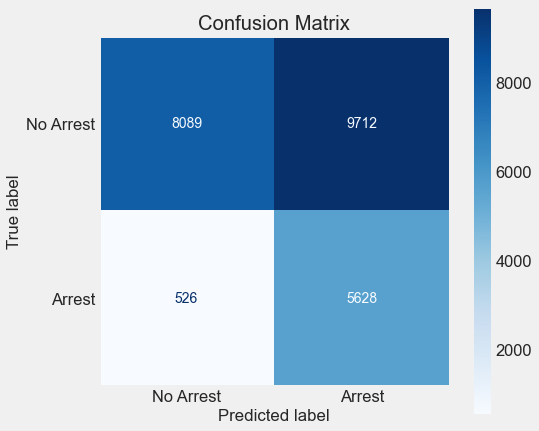

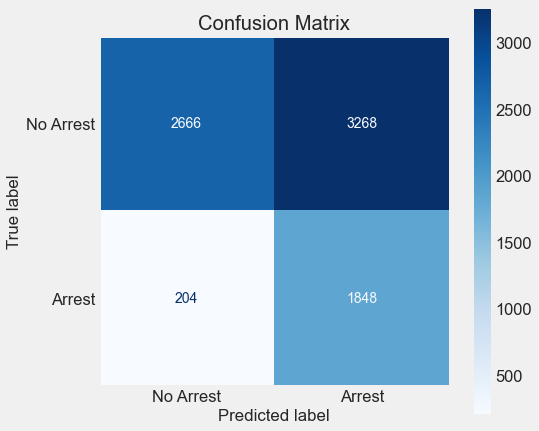

,Train F1,Test F1
0,0.523681,0.515625


In [250]:
f.subsplit_test( X_train, y_train, rf_sm_pipeline)

## Looking for Noise in the Data

In [251]:
for col in df.columns:
    print(col, df[col].nunique())

Target 2
Subject Age Group 6
Weapon Type 22
Officer ID 1153
Officer Gender 2
Officer Race 7
Subject Perceived Race 9
Subject Perceived Gender 6
Initial Call Type 165
Final Call Type 201
Call Type 6
Officer Squad 163
Frisk Flag 2
Precinct 6
Weapon Flag 2
Reported Year 7
Reported Month 12
Day of Month 31
Day of Week 7
Reported Hour 24
Beat Flag 2
Officer Age 50
Racial Affinity 2
Gender Affinity 2
Weapon Bins 4
Initial Call Bin 2
Call Type Bins 3
Officer Squad Bins 6
Officer Race Bins 2


## More Feature Engineering

In [252]:
excluded = ['Officer ID','Final Call Type', 'Weapon Type', 'Officer Gender',
            'Officer Race', 'Frisk Flag', 'Weapon Flag', 'Officer Squad', 
            'Call Type', 'Officer Squad', 'Reported Year', 'Reported Month',
            'Day of Month', 'Day of Week', 'Reported Hour']

In [253]:
df_10 = f.framer(df, [], excluded)

In [254]:
df_10.head(2)

,Target,Subject Age Group,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Precinct,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins
214,0,1 - 17,White,Male,NA,NA,0,27.0,1,1,NONE,0,OTHER,N,1
328,0,36 - 45,Asian,Male,NA,NA,0,37.0,0,1,NONE,0,OTHER,N,1


In [255]:
X, y = f.Xy(df_10)

In [256]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [257]:
# checking the small df
for col in df_10.columns:
    print(col, df_10[col].nunique())

Target 2
Subject Age Group 6
Subject Perceived Race 9
Subject Perceived Gender 6
Initial Call Type 165
Precinct 6
Beat Flag 2
Officer Age 50
Racial Affinity 2
Gender Affinity 2
Weapon Bins 4
Initial Call Bin 2
Call Type Bins 3
Officer Squad Bins 6
Officer Race Bins 2


## Exploring Initial Call

In [258]:
df['Initial Call Re-Bin'] = df['Initial Call Type'].copy()

In [259]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[0:50]

NA                                                  0.283407
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW          0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT              0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                    0.051844
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)      0.042781
TRESPASS                                            0.041090
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)           0.030313
SHOPLIFT - THEFT                                    0.029256
FIGHT - IP - PHYSICAL (NO WEAPONS)                  0.027049
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)      0.024396
ROBBERY - IP/JO (INCLUDES STRONG ARM)               0.019207
BURG - IP/JO - RES (INCL UNOCC STRUCTURES)          0.017047
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)       0.015544
DIST - IP/JO - DV DIST - NO ASLT                    0.015098
PROPERTY - DAMAGE                                   0.014675
NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)    0.014276
ASLT - IP/JO - DV       

In [260]:
categories = df['Initial Call Re-Bin'].unique()

In [261]:
alarms = [x for x in categories if 'ALARM' in x]

In [262]:
assaults = [x for x in categories if 'ASLT -' in x ]

In [263]:
burglaries = [x for x in categories if 'BURG -' in x]

In [264]:
fights = [x for x in categories if 'FIGHT -' in x]

In [265]:
weapons = [x for x in categories if 'WEAPN' in x]

In [266]:
warrants = [x for x in categories if 'WARRANT -' in x]

In [267]:
narcos = [x for x in categories if 'NARCOTICS ' in x]

In [268]:
shots = [x for x in categories if 'SHOTS' in x]

In [269]:
autos = [x for x in categories if 'AUTO ' in x]

In [270]:
for type in alarms:
    df['Initial Call Re-Bin'].replace(type, 'ALARM BIN', inplace=True)
for type in assaults:
    df['Initial Call Re-Bin'].replace(type, 'ASLT BIN', inplace=True)
for type in burglaries:
    df['Initial Call Re-Bin'].replace(type, 'BURG BIN', inplace=True)
for type in fights:
    df['Initial Call Re-Bin'].replace(type, 'FIGHT BIN', inplace=True)
for type in weapons:
    df['Initial Call Re-Bin'].replace(type, 'WEAPN BIN', inplace=True)
for type in warrants:
    df['Initial Call Re-Bin'].replace(type, 'WARRANT BIN', inplace=True)
for type in narcos:
    df['Initial Call Re-Bin'].replace(type, 'NARCOTICS BIN', inplace=True)
for type in shots:
    df['Initial Call Re-Bin'].replace(type, 'SHOTS BIN', inplace=True)
for type in autos:
    df['Initial Call Re-Bin'].replace(type, 'AUTO BIN', inplace=True)

In [271]:
df['Initial Call Re-Bin'].value_counts(normalize=True)[:50]

NA                                                 0.283407
ASLT BIN                                           0.079410
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW         0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT             0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                   0.051844
TRESPASS                                           0.041090
FIGHT BIN                                          0.040574
BURG BIN                                           0.037498
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)          0.030313
SHOPLIFT - THEFT                                   0.029256
WEAPN BIN                                          0.028622
ROBBERY - IP/JO (INCLUDES STRONG ARM)              0.019207
AUTO BIN                                           0.016483
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)      0.015544
DIST - IP/JO - DV DIST - NO ASLT                   0.015098
NARCOTICS BIN                                      0.014699
PROPERTY - DAMAGE                       

In [272]:
proportions = df['Initial Call Re-Bin'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .004].index
for i in cutoff_idx:
    df['Initial Call Re-Bin'].replace(i, 'OTHER', inplace=True)

In [273]:
df['Initial Call Re-Bin'].value_counts(normalize=True)

NA                                               0.283407
ASLT BIN                                         0.079410
OTHER                                            0.077485
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW       0.065815
SUSPICIOUS PERSON, VEHICLE OR INCIDENT           0.063091
DISTURBANCE, MISCELLANEOUS/OTHER                 0.051844
TRESPASS                                         0.041090
FIGHT BIN                                        0.040574
BURG BIN                                         0.037498
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)        0.030313
SHOPLIFT - THEFT                                 0.029256
WEAPN BIN                                        0.028622
ROBBERY - IP/JO (INCLUDES STRONG ARM)            0.019207
AUTO BIN                                         0.016483
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)    0.015544
DIST - IP/JO - DV DIST - NO ASLT                 0.015098
NARCOTICS BIN                                    0.014699
PROPERTY - DAM

## Binning Subject Race

In [274]:
df['Subject Perceived Race'].unique()

array(['White', 'Asian', 'Unknown', 'Black', 'N_American', 'Multi-Racial',
       'Hispanic', 'Other', 'P_Islander'], dtype=object)

In [275]:
df['Subject Perceived Race'].value_counts(normalize=True)

White           0.516237
Black           0.309610
Unknown         0.052290
Hispanic        0.037592
Asian           0.033952
N_American      0.030149
Multi-Racial    0.015614
Other           0.003311
P_Islander      0.001244
Name: Subject Perceived Race, dtype: float64

In [276]:
df['Subject Perceived Race'].replace('White', 0, inplace=True)
df['Subject Perceived Race'].replace('Black', 1, inplace=True)

In [277]:
types = df['Subject Perceived Race'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Race'].replace(replace_list, 3, inplace=True)

In [278]:
df['Subject Perceived Race'].value_counts(normalize=True)

0    0.516237
1    0.309610
3    0.174153
Name: Subject Perceived Race, dtype: float64

## Binning Subject Gender

In [279]:
df['Subject Perceived Gender'].unique()

array(['Male', 'Female', 'Undetermined', 'NA', 'Unknown',
       'Gender Diverse'], dtype=object)

In [280]:
df['Subject Perceived Gender'].value_counts(normalize=True)

Male              0.793820
Female            0.203503
Undetermined      0.002043
NA                0.000258
Unknown           0.000258
Gender Diverse    0.000117
Name: Subject Perceived Gender, dtype: float64

In [281]:
df['Subject Perceived Gender'].replace('Male', 0, inplace=True)
df['Subject Perceived Gender'].replace('Female', 1, inplace=True)

In [282]:
types = df['Subject Perceived Gender'].unique()
replace_list = [x for x in types if (x!=0) and (x!=1)]
df['Subject Perceived Gender'].replace(replace_list, 3, inplace=True)

In [283]:
df['Subject Perceived Gender'].value_counts(normalize=True)

0    0.793820
1    0.203503
3    0.002677
Name: Subject Perceived Gender, dtype: float64

## Small DF With Simple Data

In [284]:
# excluded = ['Officer ID','Final Call Type', 'Weapon Type',
#             'Officer Race', 'Frisk Flag', 'Weapon Flag', 'Officer Squad', 'Initial Call Type',
#             'Call Type', 'Officer Squad', 'Reported Year', 'Reported Month',
#             'Day of Month', 'Day of Week', 'Reported Hour', 'Initial Call Type','Initial Call Bin']

In [285]:
# excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag',
#            'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour']

In [286]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag']

In [287]:
df_11 = f.framer(df, [], excluded)

In [288]:
df_11.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,...,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins,Initial Call Re-Bin
214,0,1 - 17,None,Male,White,0,0,NA,NA,NA,...,0,27.0,1,1,NONE,0,OTHER,N,1,NA
328,0,36 - 45,None,Male,White,3,0,NA,NA,NA,...,0,37.0,0,1,NONE,0,OTHER,N,1,NA


In [289]:
X, y = f.Xy(df_11)

In [290]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Tuning Models on Re-Engineered Data

## LR All Data

In [291]:
LR_ALL = LogisticRegression(random_state=2021, n_jobs=-1)

In [292]:
pipeline = make_sm_pipeline(preprocessing_mm, sm, LR_ALL)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=2021))])

In [293]:
f1_score(y_train, pipeline.predict(X_train))

0.5431097692473582

In [294]:
# C = np.logspace(-4, 2, 20)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga', 'lbfgs']
# class_weight = ['balanced', None]

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#                'logisticregression__class_weight':class_weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_train, y_train)

In [295]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
# print('Best class_weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [296]:
LR_ALL_tuned = LogisticRegression(C=0.06951927961775606,
                            solver='saga', penalty='l2',
                              class_weight='balanced',
                            max_iter=1000, n_jobs=-1,
                                  random_state=2021)

pipeline  = make_sm_pipeline(preprocessing_mm, sm, LR_ALL_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_ALL_tuned', 'With Time Data')

LR_ALL_tuned has an average F1 of 0.5314877674269004


array([0.52885624, 0.53319149, 0.52876942, 0.53044597, 0.53617571])

In [297]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
3,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
4,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
5,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
6,RF 2nd Tuning,0.510214,"criterion=gini, max..."
7,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
8,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"
9,LR SMOTE,0.521328,"Dropped Nulls, mm, weapon flag"


## Testing Tuned Model on Sub-Splits

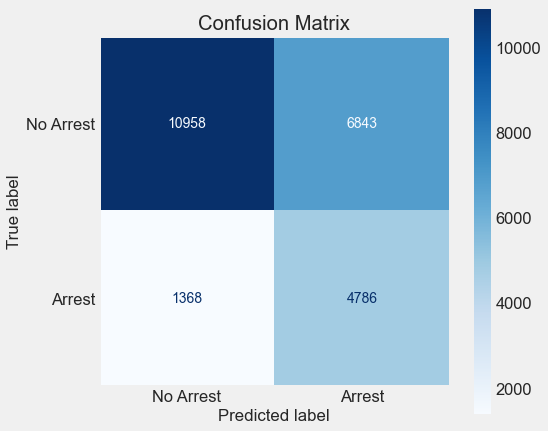

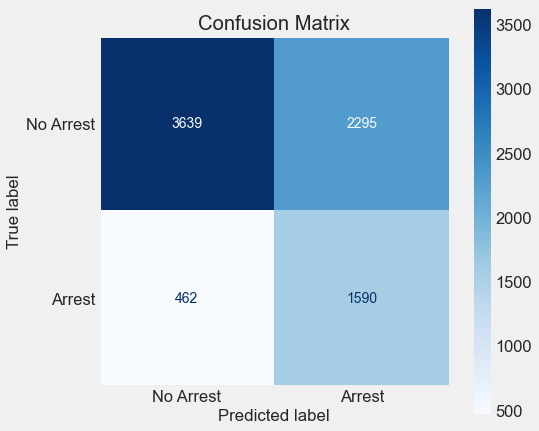

,Train F1,Test F1
0,0.538267,0.535624


In [298]:
f.subsplit_test(X_train, y_train, pipeline)

## Scores For Tuned LR on All Data

In [299]:
precision_score(y_train, pipeline.predict(X_train))

0.4109836276911177

In [300]:
accuracy_score(y_train, pipeline.predict(X_train))

0.6566168873861181

In [301]:
f1_score(y_train, pipeline.predict(X_train)) 

0.5376053962900506

In [302]:
recall_score(y_train, pipeline.predict(X_train))

0.7769924445527663

## RF Simple Data

In [303]:
RF5 = RandomForestClassifier(n_jobs=-1,
                            random_state=2021)

In [304]:
rf_sm_pipeline = make_pipeline(preprocessing_mm, RF5)
rf_sm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [305]:
# max_depth = [2, 3, 5, None]
# min_samples_split = [2, 5, 10]
# class_weight = [None, 'balanced', 'balanced_subsample']
# max_features = [None, 'auto', 'log2' ]

# grid_values = {'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__class_weight':class_weight,
#                'randomforestclassifier__max_features': max_features}

# grid_rf_f1 = GridSearchCV(rf_sm_pipeline, param_grid = grid_values, scoring = 'f1',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [306]:
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

In [307]:
# f.feature_plot(preprocessing_mm, grid_rf_f1, X_train)

In [308]:
X_train.columns

Index(['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender',
       'Initial Call Type', 'Call Type', 'Officer Squad', 'Precinct',
       'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week',
       'Reported Hour', 'Beat Flag', 'Officer Age', 'Racial Affinity',
       'Gender Affinity', 'Weapon Bins', 'Initial Call Bin', 'Call Type Bins',
       'Officer Squad Bins', 'Officer Race Bins', 'Initial Call Re-Bin'],
      dtype='object')

## Retuned Random Forest w/SMOTE

In [309]:
RF6 = RandomForestClassifier(criterion='gini',
                            max_depth=5, min_samples_split=5,
                            class_weight='balanced_subsample',
                             max_features='auto', n_jobs=-1,
                            random_state=2021)

In [310]:
rf_sm_pipeline = make_pipeline(preprocessing_mm, RF6)

In [311]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF Retuned SMOTE', 'criterion=gini,\
                            max_depth=5, min_samples_split=5,\
                            class_weight=balanced_subsample,\
                            max_features=auto')

RF Retuned SMOTE has an average F1 of 0.5003529207874842


array([0.49844847, 0.50323651, 0.49983655, 0.50115321, 0.49908986])

In [312]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
3,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
23,RF Retuned SMOTE,0.500353,"criterion=gini, max..."
4,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
5,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
6,RF 2nd Tuning,0.510214,"criterion=gini, max..."
7,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"
8,LR SMOTE,0.521148,"Dropped Nulls, mm, call type bins"


## Testing on Subsplits

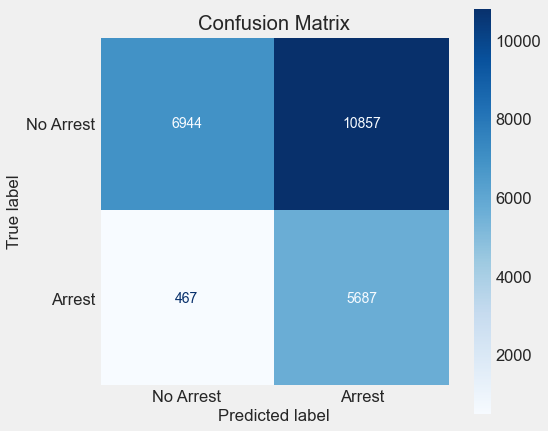

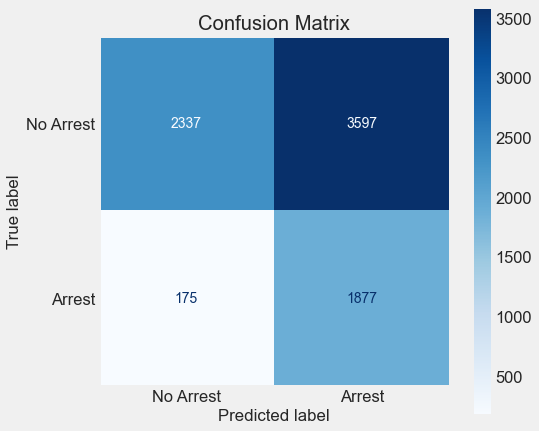

,Train F1,Test F1
0,0.501101,0.498804


In [313]:
f.subsplit_test( X_train, y_train, rf_sm_pipeline)

## Scores For Tuned RF on Simple Data

In [314]:
precision_score(y_train, rf_sm_pipeline.predict(X_train))

0.3435371060041784

In [315]:
accuracy_score(y_train, rf_sm_pipeline.predict(X_train))

0.5273786043016813

In [316]:
f1_score(y_train, rf_sm_pipeline.predict(X_train))

0.5005293806246691

In [317]:
recall_score(y_train, rf_sm_pipeline.predict(X_train))

0.9217645625152328

## RF Simple Data Precision GSCV

In [318]:
# max_depth = [2, 3, 5, None]
# min_samples_split = [2, 5, 10, 15 ,20]
# class_weight = [None, 'balanced', 'balanced_subsample']
# max_features = [None, 'auto', 'log2' ]

# grid_values = {'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#                'randomforestclassifier__class_weight':class_weight,
#                'randomforestclassifier__max_features': max_features}

# grid_rf_f1 = GridSearchCV(rf_sm_pipeline, param_grid = grid_values, scoring = 'precision',
#                           n_jobs=-1, verbose=2, cv=3)
# grid_rf_f1.fit(X_train, y_train)

In [319]:
# print('Best max_features:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_features'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

## Feature Importance

In [320]:
# f.feature_plot(preprocessing_mm, grid_rf_f1, X_train)

## Tweaking Class_Weight RF w/SMOTE

In [321]:
RF6 = RandomForestClassifier(criterion='gini',
                            max_depth=5, min_samples_split=5,
                            class_weight={0:.2, 1:.35},
                             max_features='auto', n_jobs=-1,
                            random_state=2021)

In [322]:
rf_sm_pipeline = make_pipeline(preprocessing_mm, RF6)

In [323]:
modeling.report(rf_sm_pipeline, X_train, y_train, 'RF Precision Tuned', 'criterion=gini,\
                            max_depth=5, min_samples_split=5,\
                            class_weight=None')

RF Precision Tuned has an average F1 of 0.2240022670224476


array([0.23671498, 0.19521912, 0.23454367, 0.22011952, 0.23341404])

In [324]:
modeling.history

,Name,Accuracy,Notes
24,RF Precision Tuned,0.224002,"criterion=gini, max..."
0,LR Baseline,0.308460,"Log Reg, min/max"
1,RandomForest,0.381260,Forest No SMOTE
2,RandomForest,0.420350,Forest SMOTE
3,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
4,RF Retuned SMOTE,0.500353,"criterion=gini, max..."
5,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
6,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
7,RF 2nd Tuning,0.510214,"criterion=gini, max..."
8,LR SMOTE,0.513197,"Dropped Nulls, mm, Squad Bins"


## Testing on Subsplits

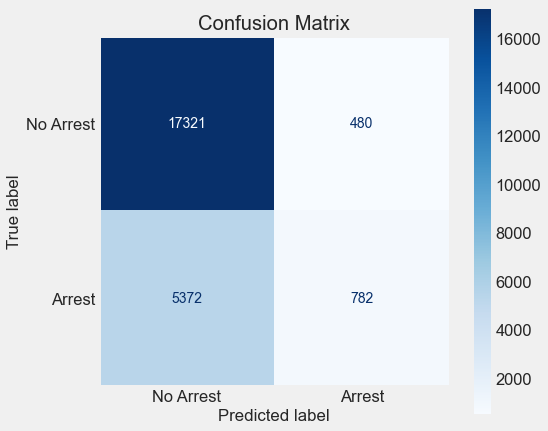

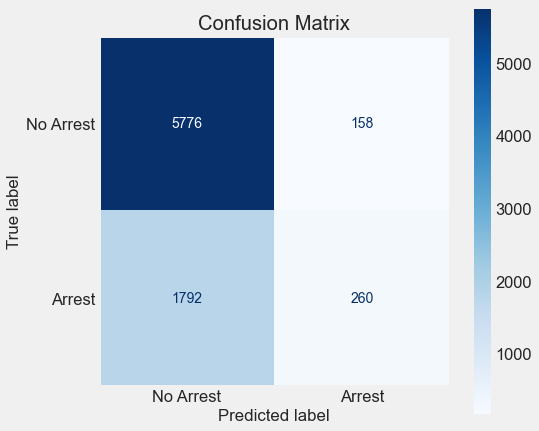

,Train F1,Test F1
0,0.210895,0.210526


In [325]:
f.subsplit_test( X_train, y_train, rf_sm_pipeline)

## Scores For Precision Tuned RF on Simple Data

In [326]:
precision_score(y_train, rf_sm_pipeline.predict(X_train))

0.6202380952380953

In [327]:
accuracy_score(y_train, rf_sm_pipeline.predict(X_train))

0.7557371403525249

In [328]:
f1_score(y_train, rf_sm_pipeline.predict(X_train))

0.21080315597815094

In [329]:
recall_score(y_train, rf_sm_pipeline.predict(X_train))

0.12698025834755058

## AdaBoost

In [330]:
ada = AdaBoostClassifier(random_state=2021)

ada_pipeline = make_sm_pipeline(preprocessing_mm, sm, ada)

In [331]:
ada_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('adaboostclassifier', AdaBoostClassifier(random_state=2021))])

In [332]:
# checking cross val scores
modeling.report(ada_pipeline, X_train, y_train,\
                'AdaBoost', 'Simple Data')

AdaBoost has an average F1 of 0.45699878784460585


array([0.45297806, 0.44643327, 0.47551343, 0.46438821, 0.44568098])

In [333]:
#scoring the model
f1_score(y_train, ada_pipeline.predict(X_train))

0.47028932904697707

In [334]:
modeling.history

,Name,Accuracy,Notes
0,RF Precision Tuned,0.224002,"criterion=gini, max..."
1,LR Baseline,0.308460,"Log Reg, min/max"
2,RandomForest,0.381260,Forest No SMOTE
3,RandomForest,0.420350,Forest SMOTE
25,AdaBoost,0.456999,Simple Data
4,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
5,RF Retuned SMOTE,0.500353,"criterion=gini, max..."
6,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
7,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
8,RF 2nd Tuning,0.510214,"criterion=gini, max..."


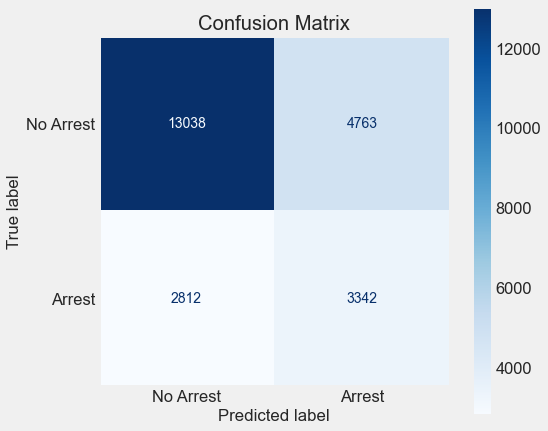

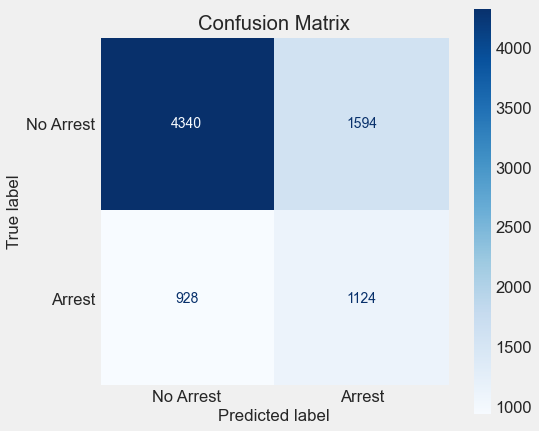

,Train F1,Test F1
0,0.468757,0.471279


In [335]:
f.subsplit_test(X_train, y_train, ada_pipeline)

## AdaBoost with LR

In [336]:
ada = AdaBoostClassifier(base_estimator=LR_tuned, random_state=2021)

adaLR_pipeline = make_sm_pipeline(preprocessing_mm, sm, ada)

In [337]:
adaLR_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=LogisticRegression(C=2.154434690031884,
                                                                      max_iter=1000,
                                                                      n_jobs=-1,
                                                 

In [338]:
# checking cross val scores
modeling.report(adaLR_pipeline, X_train, y_train,\
                'AdaBoostLR', 'Simple Data')

AdaBoostLR has an average F1 of 0.5182834932088987


array([0.52237654, 0.51684953, 0.52302888, 0.51022013, 0.51894238])

In [339]:
#scoring the model
f1_score(y_train, adaLR_pipeline.predict(X_train))

0.5220413103744486

In [340]:
modeling.history

,Name,Accuracy,Notes
0,RF Precision Tuned,0.224002,"criterion=gini, max..."
1,LR Baseline,0.308460,"Log Reg, min/max"
2,RandomForest,0.381260,Forest No SMOTE
3,RandomForest,0.420350,Forest SMOTE
4,AdaBoost,0.456999,Simple Data
5,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
6,RF Retuned SMOTE,0.500353,"criterion=gini, max..."
7,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
8,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
9,RF 2nd Tuning,0.510214,"criterion=gini, max..."


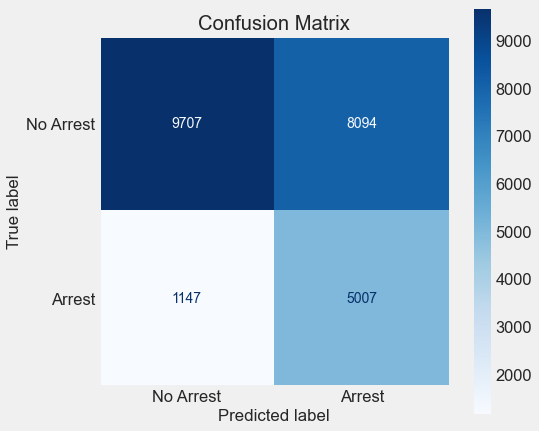

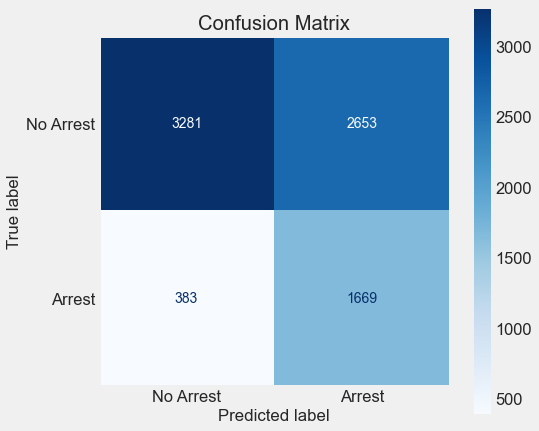

,Train F1,Test F1
0,0.520073,0.52369


In [341]:
f.subsplit_test(X_train, y_train, adaLR_pipeline)

## AdaLR Tuned

In [342]:
# adaLR_pipeline.get_params().keys()

In [343]:
# parameters = {
#               'adaboostclassifier__n_estimators':[10,50,100,250],
#               'adaboostclassifier__learning_rate':[.01,.1,.5, 1]}

# adaGCV = GridSearchCV(adaLR_pipeline, parameters,verbose=2,
#                    scoring='f1',n_jobs=-1, cv=3)
# adaGCV.fit(X_train,y_train)

In [344]:
# print('Best learning_rate:', adaGCV.best_estimator_.get_params()['adaboostclassifier__learning_rate'])
# print('Best n_estimators:', adaGCV.best_estimator_.get_params()['adaboostclassifier__n_estimators'])

In [345]:
ada = AdaBoostClassifier(base_estimator=LR_tuned, learning_rate=1,
                         n_estimators=250, random_state=2021)

adaLR_tuned = make_sm_pipeline(preprocessing_mm, sm, ada)

In [346]:
adaLR_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=LogisticRegression(C=2.154434690031884,
                                                                      max_iter=1000,
                                                                      n_jobs=-1,
                                                 

In [347]:
# checking cross val scores
modeling.report(adaLR_tuned, X_train, y_train,\
                'AdaBoostLR Tuned', 'Simple Data')

AdaBoostLR Tuned has an average F1 of 0.5275885884996503


array([0.52753623, 0.52772547, 0.52640264, 0.5250949 , 0.53118371])

In [348]:
#scoring the model
f1_score(y_train, adaLR_tuned.predict(X_train))

0.5342168875552221

In [349]:
modeling.history

,Name,Accuracy,Notes
0,RF Precision Tuned,0.224002,"criterion=gini, max..."
1,LR Baseline,0.308460,"Log Reg, min/max"
2,RandomForest,0.381260,Forest No SMOTE
3,RandomForest,0.420350,Forest SMOTE
4,AdaBoost,0.456999,Simple Data
5,RF Tuned No SMOTE,0.499568,"criterion=gini, max..."
6,RF Retuned SMOTE,0.500353,"criterion=gini, max..."
7,LR SMOTE,0.503913,"Dropped Nulls, mm, Initial Call Binary"
8,RF Tuned SMOTE,0.505727,"criterion=gini, max..."
9,RF 2nd Tuning,0.510214,"criterion=gini, max..."


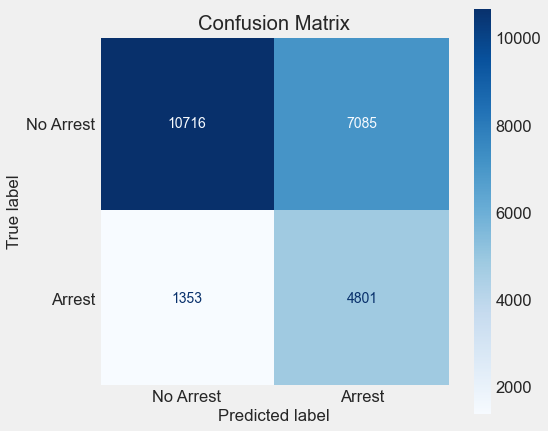

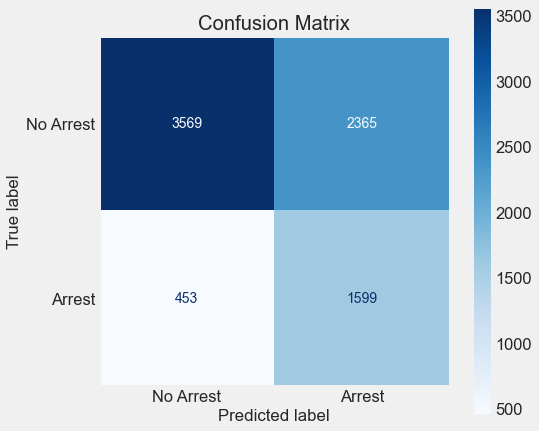

,Train F1,Test F1
0,0.532262,0.531582


In [350]:
f.subsplit_test(X_train, y_train, adaLR_tuned)

## Plotting a DT

In [351]:
X, y = f.Xy(df_11)

In [352]:
X.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,...,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins,Initial Call Bin,Call Type Bins,Officer Squad Bins,Officer Race Bins,Initial Call Re-Bin
214,1 - 17,None,Male,White,0,0,NA,NA,NA,NA,...,0,27.0,1,1,NONE,0,OTHER,N,1,NA
328,36 - 45,None,Male,White,3,0,NA,NA,NA,NA,...,0,37.0,0,1,NONE,0,OTHER,N,1,NA
654,46 - 55,None,Male,White,0,0,NA,NA,NA,NA,...,0,38.0,1,1,NONE,0,OTHER,N,1,NA
1051,1 - 17,None,Male,White,3,0,NA,NA,SOUTH PCT 2ND W - SAM,South,...,1,32.0,0,1,NONE,0,OTHER,S,1,NA
1079,1 - 17,None,Male,White,0,0,NA,NA,NORTH PCT 3RD W - UNION,NA,...,0,42.0,1,1,NONE,0,OTHER,N,1,NA


In [353]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [354]:
DT = DecisionTreeClassifier(max_depth=5, random_state=2021)

In [355]:
pipeline = make_sm_pipeline(preprocessing_mm, sm, DT)

In [356]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state=2021)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=2021))])

In [357]:
f1_score(y_train, pipeline.predict(X_train))

0.46015332501337136

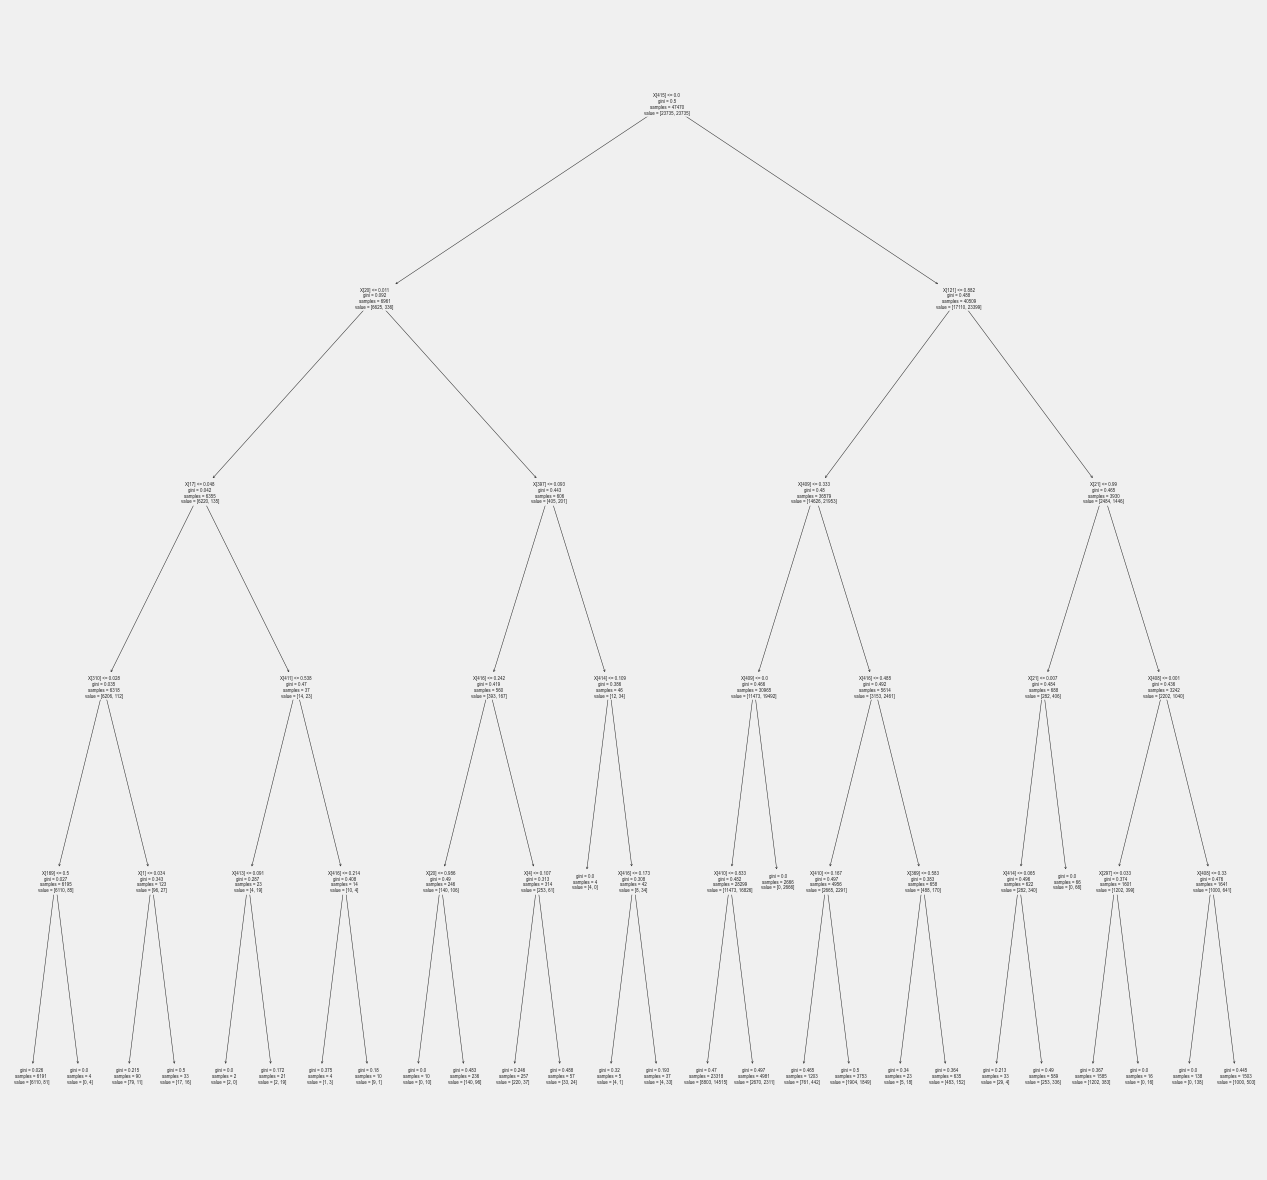

In [358]:
plt.figure(figsize=(20,20))
plot_tree(pipeline[2])
plt.show()

In [359]:
# f.plot_feature_importances(pipeline[2], X_train)

## DT 2 

In [360]:
# X, y = f.Xy(df_11)

In [361]:
# X.head()

In [362]:
# X_train, X_test, y_train, y_test = f.splitter(X, y)

In [363]:
# train_num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
# test_num_cols = X_test.columns[X_test.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [364]:
# mm = MinMaxScaler()

# X_train[train_num_cols] = mm.fit_transform(X_train[train_num_cols])
# X_test[test_num_cols] = mm.fit_transform(X_test[test_num_cols])

In [365]:
# ohe = OneHotEncoder()
# X_train = ohe.fit_transform(X_train)

In [366]:
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)

In [367]:
# Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [368]:
# X_train,y_train = sm.fit_resample(X_train,y_train)

In [369]:
# X_train.head(2)

In [370]:
# DT.fit(X_train, y_train)

In [371]:
# f1_score(y_train, DT.predict(X_train))

In [372]:
# DT.fit(Xs_train, ys_train)

In [373]:
# f1_score(ys_test, DT.predict(Xs_test))

In [374]:
# plt.figure(figsize=(20,20))
# plot_tree(DT)
# plt.show()

In [375]:
# for x in X_train.columns:
#     print(x, X_train.columns.get_loc(x))    

In [376]:
# f.plot_feature_importances(DT, X_train)

## XGBoost

In [377]:
xboostclf = xgb.XGBClassifier(use_label_encoder=False)

In [378]:
X, y = f.Xy(df_11)

In [379]:
X_train, X_test, y_train, y_test = f.splitter(X, y)

In [380]:
xpipeline = make_sm_pipeline(preprocessing_mm, sm, xboostclf)

In [381]:
xpipeline.fit(X_train, y_train)

[23:23:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('smote', SMOTE(random_state...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

In [382]:
rf_sm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a8b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc23779a520>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.2, 1: 0.35},
                                        max_depth=5, min_samples_split=5,
                                        n_jobs=-1, random_state=2021))])

In [383]:
modeling.report(xpipeline, X_train, y_train, 'XGBCLF', '1st Run' )

[23:23:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

array([0.35435435, 0.31894273, 0.32761578, 0.33172867, 0.34428384])

### Checking Feature Names

In [ ]:
xpipeline.steps[0][1].transformers_[0][1].get_feature_names()

In [ ]:
# plt.figure(figsize=(50,10))
xgb.plot_tree(xboostclf,num_trees=0)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xboostclf, num_trees=0, ax=ax)
plt.show()

In [ ]:
xgb.plot_tree(xboostclf)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
xgb.plot_tree(xboostclf, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

## Boruta 

In [ ]:
X, y = f.Xy(df_11)

In [ ]:
X.head()

In [ ]:
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [ ]:
mm = MinMaxScaler()

X[num_cols] = mm.fit_transform(X[num_cols])

In [ ]:
X = pd.get_dummies(X)

In [ ]:
X.head(2)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta 
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=2021)

# fit selector
feat_selector.fit(X.values, y.values)

In [ ]:
#  get list of features
keep = X.columns[feat_selector.support_].to_list()
toss = X.columns[feat_selector.support_weak_].to_list()
print('features to keep:', keep)
print('features to toss:', toss)

In [ ]:
#  get rankings
X.columns[feat_selector.ranking_].sort_values(ascending=False).to_list()

In [ ]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X.values)

In [ ]:
boruta = pd.DataFrame(X_filtered)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(boruta, y)

In [ ]:
boruta_selected.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(boruta_selected.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(boruta_selected, X_train, y_train, 'RF ', 'Boruta Selected')

In [ ]:
modeling.history